In [25]:
# mnist를 활용한 Gan 연습.

# import tensorflow 
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU , UpSampling2D, Conv2D, ReLU
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt

# 가상의 이미지를 만드는 생성자 모델 만들기

generator = Sequential() # 모델 이름을 generator로 정하기
generator.add(Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2)))
# 128은 임의로 정한 노드의 수. 충분한 노드 마련해주면 됨.
# input_dim = 100 은 100차원 크기의 랜덤 벡터를 준비해 넣으면 됨.
# mnist손글씨 이미지는 28*28이다. 그런데 7*7을 넣어주는건, 뒤에 upsampling2D를 두번해서 크기를 키워줌.
generator.add(BatchNormalization()) # 입력 데이터의 평균이 0, 분산이 1이 되도록 재배치하는 과정.
# 다음 층으로 입력될 값을 일정하게 재배치 하는 역할 -> 층의 개수가 늘어나도 안정적 학습 진행 가능
generator.add(Reshape((7, 7, 128))) # 컨볼루션 레이어가 받아들일 수 있는 형태로 변환.
generator.add(UpSampling2D()) # 레이어 지나며 크기가 2배로 커짐. 14 * 14
generator.add(Conv2D(64, kernel_size = 5, padding = 'same')) # padding이 same이므로 자동으로 0이 채워짐.
generator.add(BatchNormalization()) # 정규분포로 만드는 배치 정규화
generator.add(Activation(LeakyReLU(0.2))) # Gan에서는 학습 안정성을 위해 relu 대신 leakyrelu를 사용.
# 0보다 작을경우 0.2를 곱해줌.
generator.add(UpSampling2D()) # 28 * 28
generator.add(Conv2D(1, kernel_size = 5, padding = 'same', activation = 'tanh'))
# 컨볼루션 과정 거치며 판별자로 넘길 준비. 활성화 함수는 tanh을 사용하여 출력갑승ㄹ -1~ 1로 맞춤.

In [26]:
# 진위를 가려내는 판별자 모델 만들기
# 진짜인지 가짜인지 판별만 해주어야 하므로 자기자신이 학습해서는 안됨.

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size = 5, strides = 2, input_shape = (28, 28, 1), padding = "same"))
# strides = 2를 써서 크기를 더 줄여 새로운 특징을 뽑아내는 효과사용 (차원을 적극적으로 줄여줌.)
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten()) # 1차원으로 변환.
discriminator.add(Dense(1, activation = 'sigmoid'))

# 모델 컴파일하기
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam')
discriminator.trainable = False # 판별자가 얻은 가중치는 생성자로 넘겨주어야함.
# 생서자가 업데이트된 이미지를 만들어야 하므로 가중치를 저장하는 학습 기능을 꺼주어야함.

In [27]:
# 생성자와 판별자 모델을 연결시키는 gan모델 만들기
ginput = Input(shape = (100, )) # 랜덤한 100개의 벡터를 케라스의 input 함수에 집어넣기
# 생성자에 입력할 ginput만들기
dis_output = discriminator(generator(ginput)) # 생성자에 ginput넣고 판별자에 넣기
gan = Model(ginput, dis_output) # ginput값과 판별자의 결과 비교 모델만들기
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_15 (Sequential)   (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_16 (Sequential)   (None, 1)                 14209     
Total params: 879,490
Trainable params: 852,609
Non-trainable params: 26,881
_________________________________________________________________


In [29]:
# 신경망 실행시키는 함수 만들고 Mnist 데이터 불러오기


def gan_train(epoch, batch_size, saving_interval):
    # 테스트 과정은 필요없고, 이미지만 사용할 것이므로 X_train만 호출하기
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
    
    # 생성자에서 tanh()함수 사용했었음. 
    # 0~ 255 사이의 픽셀 값에서 127.5를 뺀 후, 127.5로 나누면 -1~1사이의 값으로 바뀐다.
    X_train = (X_train - 127.5) / 127.5
    # batch_size만큼 손글시 이미지 랜덤하게 불러와서 판별자에 집어넣기.
    #실제 이미지를 입력했으므로 모두 참이라는 1이라는 레이블을 가진 배열(1열)만들기
    true = np.ones((batch_size, 1))
    # 가짜 0이라는 레이블을 가진 배열(1열) 만들기.
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        # 실제 이미지를 랜덤으로 불러옴. randint(a, b, c)sms a~b까지의 숫자중 하나를 랜덤하게 가져와서 c번 반복하기.
        # 0부터 x_train 개수 사이의 숫자를 랜덤으로 batch사이즈 만큼 가져옴.
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx] # 위에서 선택된 숫자에 해당하는 이미지 불러오기
        # train_on_batch()함수로 판별 시작. 입력값 x와 레이블 y를 받아서 학습실시하고 모델 업데이트하기.
        d_loss_real = discriminator.train_on_batch(imgs, true) # imgs를 x에 넣고 true값 배열을 y에 놓기
        
        # 가상 이미지를 판별자에 입력하기
        noise = np.random.normal(0, 1, (batch_size, 100)) # 정수가 아니라서 normal함수사용. batch사이즈만큼 100열을 뽑아라.
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # gen_imgs에 가짜(0)이라는 레이블 값이 붙음.
        
        # 판별자와 생성자의 오차 계산하기
        # real이미지 판별값과 fake이미지 판별값을 더해 둘로 나눈 평균이 판별자 오차.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true) # 생성자와 판별자를 연결해서 만든 gan모델을 이용해 생성자 오차 g_loss구하기
        
        print('epoch:%d' % i, 'd_loss: % .4f' % d_loss, 'g_loss: % .4f' % g_loss)
        
gan_train(4001, 32, 200) # 4000번 반복되고 +1을 한다. 배치크기 32, 200번마다 결과 저장됨.

epoch:0 d_loss:  0.5621 g_loss:  0.3143
epoch:1 d_loss:  0.4522 g_loss:  0.0774
epoch:2 d_loss:  0.4785 g_loss:  0.0204
epoch:3 d_loss:  0.5121 g_loss:  0.0105
epoch:4 d_loss:  0.5353 g_loss:  0.0095
epoch:5 d_loss:  0.5307 g_loss:  0.0164
epoch:6 d_loss:  0.5179 g_loss:  0.0425
epoch:7 d_loss:  0.4817 g_loss:  0.1428
epoch:8 d_loss:  0.4418 g_loss:  0.3682
epoch:9 d_loss:  0.4551 g_loss:  0.5633
epoch:10 d_loss:  0.4698 g_loss:  0.6042
epoch:11 d_loss:  0.4499 g_loss:  0.5444
epoch:12 d_loss:  0.4230 g_loss:  0.4903
epoch:13 d_loss:  0.4178 g_loss:  0.4755
epoch:14 d_loss:  0.3851 g_loss:  0.5051
epoch:15 d_loss:  0.3583 g_loss:  0.6226
epoch:16 d_loss:  0.3407 g_loss:  0.7767
epoch:17 d_loss:  0.3238 g_loss:  0.9515
epoch:18 d_loss:  0.3685 g_loss:  0.9863
epoch:19 d_loss:  0.5500 g_loss:  0.8279
epoch:20 d_loss:  0.5930 g_loss:  0.5271
epoch:21 d_loss:  0.6234 g_loss:  0.3479
epoch:22 d_loss:  0.6618 g_loss:  0.2023
epoch:23 d_loss:  0.5335 g_loss:  0.1617
epoch:24 d_loss:  0.3957 g

epoch:199 d_loss:  0.6802 g_loss:  1.0009
epoch:200 d_loss:  0.6171 g_loss:  1.0265
epoch:201 d_loss:  0.5902 g_loss:  1.0069
epoch:202 d_loss:  0.5540 g_loss:  1.1489
epoch:203 d_loss:  0.5167 g_loss:  1.0246
epoch:204 d_loss:  0.5265 g_loss:  1.0541
epoch:205 d_loss:  0.4702 g_loss:  1.1807
epoch:206 d_loss:  0.4620 g_loss:  1.0352
epoch:207 d_loss:  0.4456 g_loss:  0.9918
epoch:208 d_loss:  0.4404 g_loss:  0.9503
epoch:209 d_loss:  0.4839 g_loss:  0.9460
epoch:210 d_loss:  0.4314 g_loss:  0.9008
epoch:211 d_loss:  0.5693 g_loss:  0.7275
epoch:212 d_loss:  0.5198 g_loss:  0.7714
epoch:213 d_loss:  0.5733 g_loss:  0.7030
epoch:214 d_loss:  0.5084 g_loss:  0.7997
epoch:215 d_loss:  0.6144 g_loss:  0.8027
epoch:216 d_loss:  0.5262 g_loss:  0.7492
epoch:217 d_loss:  0.6555 g_loss:  0.5771
epoch:218 d_loss:  0.6667 g_loss:  0.6456
epoch:219 d_loss:  0.5936 g_loss:  0.6346
epoch:220 d_loss:  0.7280 g_loss:  0.5211
epoch:221 d_loss:  0.8057 g_loss:  0.5545
epoch:222 d_loss:  0.8973 g_loss: 

epoch:395 d_loss:  0.6688 g_loss:  0.8863
epoch:396 d_loss:  0.5519 g_loss:  0.9448
epoch:397 d_loss:  0.4848 g_loss:  0.9686
epoch:398 d_loss:  0.5260 g_loss:  1.0767
epoch:399 d_loss:  0.6081 g_loss:  0.9316
epoch:400 d_loss:  0.5444 g_loss:  0.9614
epoch:401 d_loss:  0.6025 g_loss:  0.8989
epoch:402 d_loss:  0.5664 g_loss:  0.8562
epoch:403 d_loss:  0.5532 g_loss:  0.9215
epoch:404 d_loss:  0.6087 g_loss:  0.8149
epoch:405 d_loss:  0.5979 g_loss:  0.9559
epoch:406 d_loss:  0.6230 g_loss:  0.8691
epoch:407 d_loss:  0.7410 g_loss:  0.8746
epoch:408 d_loss:  0.6921 g_loss:  0.8779
epoch:409 d_loss:  0.6776 g_loss:  0.7864
epoch:410 d_loss:  0.6786 g_loss:  0.7671
epoch:411 d_loss:  0.8294 g_loss:  0.8214
epoch:412 d_loss:  0.7850 g_loss:  0.7467
epoch:413 d_loss:  0.8048 g_loss:  0.7138
epoch:414 d_loss:  0.7780 g_loss:  0.7099
epoch:415 d_loss:  0.8763 g_loss:  0.6970
epoch:416 d_loss:  0.8206 g_loss:  0.7378
epoch:417 d_loss:  0.8692 g_loss:  0.6871
epoch:418 d_loss:  0.8322 g_loss: 

epoch:591 d_loss:  0.4958 g_loss:  1.0285
epoch:592 d_loss:  0.4436 g_loss:  0.9902
epoch:593 d_loss:  0.4702 g_loss:  1.0488
epoch:594 d_loss:  0.4541 g_loss:  1.0665
epoch:595 d_loss:  0.5521 g_loss:  1.1362
epoch:596 d_loss:  0.4641 g_loss:  1.1778
epoch:597 d_loss:  0.4668 g_loss:  1.1689
epoch:598 d_loss:  0.4362 g_loss:  1.3228
epoch:599 d_loss:  0.4136 g_loss:  1.2759
epoch:600 d_loss:  0.5476 g_loss:  1.2147
epoch:601 d_loss:  0.4752 g_loss:  1.1990
epoch:602 d_loss:  0.5135 g_loss:  1.2969
epoch:603 d_loss:  0.4125 g_loss:  1.2756
epoch:604 d_loss:  0.4405 g_loss:  1.2616
epoch:605 d_loss:  0.4062 g_loss:  1.2009
epoch:606 d_loss:  0.4541 g_loss:  1.2923
epoch:607 d_loss:  0.4386 g_loss:  0.9942
epoch:608 d_loss:  0.5620 g_loss:  1.0602
epoch:609 d_loss:  0.5332 g_loss:  1.1257
epoch:610 d_loss:  0.6030 g_loss:  0.9249
epoch:611 d_loss:  0.6265 g_loss:  0.9551
epoch:612 d_loss:  0.5859 g_loss:  0.9723
epoch:613 d_loss:  0.5660 g_loss:  1.0146
epoch:614 d_loss:  0.6089 g_loss: 

epoch:787 d_loss:  0.5374 g_loss:  1.0533
epoch:788 d_loss:  0.4889 g_loss:  1.0611
epoch:789 d_loss:  0.4747 g_loss:  1.1687
epoch:790 d_loss:  0.4884 g_loss:  1.1554
epoch:791 d_loss:  0.5194 g_loss:  1.1082
epoch:792 d_loss:  0.4434 g_loss:  1.1356
epoch:793 d_loss:  0.5341 g_loss:  1.0657
epoch:794 d_loss:  0.4856 g_loss:  1.2822
epoch:795 d_loss:  0.5213 g_loss:  1.1098
epoch:796 d_loss:  0.4579 g_loss:  1.1842
epoch:797 d_loss:  0.5235 g_loss:  1.0166
epoch:798 d_loss:  0.4312 g_loss:  1.1856
epoch:799 d_loss:  0.5643 g_loss:  1.0680
epoch:800 d_loss:  0.4878 g_loss:  1.1210
epoch:801 d_loss:  0.5686 g_loss:  1.0641
epoch:802 d_loss:  0.5399 g_loss:  1.2400
epoch:803 d_loss:  0.5470 g_loss:  1.1063
epoch:804 d_loss:  0.5673 g_loss:  1.1540
epoch:805 d_loss:  0.5880 g_loss:  0.9821
epoch:806 d_loss:  0.5863 g_loss:  1.0284
epoch:807 d_loss:  0.5445 g_loss:  1.0772
epoch:808 d_loss:  0.5906 g_loss:  1.1697
epoch:809 d_loss:  0.5464 g_loss:  1.1173
epoch:810 d_loss:  0.5363 g_loss: 

epoch:982 d_loss:  0.4963 g_loss:  1.1450
epoch:983 d_loss:  0.5674 g_loss:  1.1153
epoch:984 d_loss:  0.5092 g_loss:  1.0978
epoch:985 d_loss:  0.4960 g_loss:  1.0403
epoch:986 d_loss:  0.5352 g_loss:  1.0947
epoch:987 d_loss:  0.5086 g_loss:  1.1619
epoch:988 d_loss:  0.5229 g_loss:  1.0957
epoch:989 d_loss:  0.4921 g_loss:  1.1184
epoch:990 d_loss:  0.5617 g_loss:  1.1078
epoch:991 d_loss:  0.4188 g_loss:  1.1995
epoch:992 d_loss:  0.4180 g_loss:  1.2252
epoch:993 d_loss:  0.4491 g_loss:  1.3233
epoch:994 d_loss:  0.4081 g_loss:  1.2192
epoch:995 d_loss:  0.4268 g_loss:  1.1884
epoch:996 d_loss:  0.3993 g_loss:  1.3017
epoch:997 d_loss:  0.4470 g_loss:  1.2795
epoch:998 d_loss:  0.4205 g_loss:  1.3512
epoch:999 d_loss:  0.3420 g_loss:  1.3090
epoch:1000 d_loss:  0.3945 g_loss:  1.3054
epoch:1001 d_loss:  0.3202 g_loss:  1.4993
epoch:1002 d_loss:  0.3826 g_loss:  1.5064
epoch:1003 d_loss:  0.3679 g_loss:  1.3701
epoch:1004 d_loss:  0.3547 g_loss:  1.4678
epoch:1005 d_loss:  0.3655 g_

epoch:1173 d_loss:  0.3751 g_loss:  1.3554
epoch:1174 d_loss:  0.4029 g_loss:  1.1457
epoch:1175 d_loss:  0.4457 g_loss:  1.2430
epoch:1176 d_loss:  0.5197 g_loss:  1.0933
epoch:1177 d_loss:  0.4005 g_loss:  1.3559
epoch:1178 d_loss:  0.4917 g_loss:  1.1281
epoch:1179 d_loss:  0.5832 g_loss:  1.0410
epoch:1180 d_loss:  0.4757 g_loss:  1.3489
epoch:1181 d_loss:  0.6348 g_loss:  1.4044
epoch:1182 d_loss:  0.6070 g_loss:  1.3991
epoch:1183 d_loss:  0.6614 g_loss:  1.3345
epoch:1184 d_loss:  0.6309 g_loss:  1.2910
epoch:1185 d_loss:  0.6421 g_loss:  1.4453
epoch:1186 d_loss:  0.7602 g_loss:  1.3106
epoch:1187 d_loss:  0.6762 g_loss:  1.0362
epoch:1188 d_loss:  0.6122 g_loss:  1.1103
epoch:1189 d_loss:  0.6402 g_loss:  1.3640
epoch:1190 d_loss:  0.5507 g_loss:  1.5889
epoch:1191 d_loss:  0.7399 g_loss:  1.3994
epoch:1192 d_loss:  0.7900 g_loss:  1.2820
epoch:1193 d_loss:  0.5839 g_loss:  1.5133
epoch:1194 d_loss:  0.5550 g_loss:  1.2442
epoch:1195 d_loss:  0.6835 g_loss:  1.0953
epoch:1196 

epoch:1365 d_loss:  0.6237 g_loss:  1.0791
epoch:1366 d_loss:  0.4922 g_loss:  1.5046
epoch:1367 d_loss:  0.4076 g_loss:  1.4082
epoch:1368 d_loss:  0.5909 g_loss:  1.5585
epoch:1369 d_loss:  0.4364 g_loss:  1.4079
epoch:1370 d_loss:  0.6261 g_loss:  1.2108
epoch:1371 d_loss:  0.6232 g_loss:  1.2825
epoch:1372 d_loss:  0.5113 g_loss:  1.2779
epoch:1373 d_loss:  0.5543 g_loss:  1.2722
epoch:1374 d_loss:  0.6686 g_loss:  1.1272
epoch:1375 d_loss:  0.5529 g_loss:  1.0935
epoch:1376 d_loss:  0.4637 g_loss:  1.2561
epoch:1377 d_loss:  0.5963 g_loss:  0.9427
epoch:1378 d_loss:  0.5652 g_loss:  0.8485
epoch:1379 d_loss:  0.5492 g_loss:  0.8930
epoch:1380 d_loss:  0.7902 g_loss:  0.7384
epoch:1381 d_loss:  0.8600 g_loss:  0.6431
epoch:1382 d_loss:  0.6640 g_loss:  0.5527
epoch:1383 d_loss:  0.9379 g_loss:  0.4505
epoch:1384 d_loss:  0.9641 g_loss:  0.4845
epoch:1385 d_loss:  1.1077 g_loss:  0.2884
epoch:1386 d_loss:  1.3858 g_loss:  0.5139
epoch:1387 d_loss:  1.1293 g_loss:  0.4010
epoch:1388 

epoch:1557 d_loss:  0.5726 g_loss:  0.9794
epoch:1558 d_loss:  0.6647 g_loss:  0.9470
epoch:1559 d_loss:  0.8170 g_loss:  0.7545
epoch:1560 d_loss:  0.8783 g_loss:  0.6686
epoch:1561 d_loss:  0.6541 g_loss:  0.6274
epoch:1562 d_loss:  0.6599 g_loss:  0.5995
epoch:1563 d_loss:  0.7715 g_loss:  0.6262
epoch:1564 d_loss:  0.5969 g_loss:  0.7755
epoch:1565 d_loss:  0.5474 g_loss:  1.0030
epoch:1566 d_loss:  0.5663 g_loss:  1.0066
epoch:1567 d_loss:  0.4529 g_loss:  1.1106
epoch:1568 d_loss:  0.5014 g_loss:  1.1949
epoch:1569 d_loss:  0.4210 g_loss:  1.1973
epoch:1570 d_loss:  0.5008 g_loss:  1.1363
epoch:1571 d_loss:  0.4374 g_loss:  1.1609
epoch:1572 d_loss:  0.5188 g_loss:  1.1177
epoch:1573 d_loss:  0.5205 g_loss:  1.0516
epoch:1574 d_loss:  0.4939 g_loss:  1.0388
epoch:1575 d_loss:  0.4927 g_loss:  1.0214
epoch:1576 d_loss:  0.5586 g_loss:  1.0276
epoch:1577 d_loss:  0.5577 g_loss:  0.9540
epoch:1578 d_loss:  0.5737 g_loss:  0.9236
epoch:1579 d_loss:  0.6013 g_loss:  0.9869
epoch:1580 

epoch:1748 d_loss:  0.8145 g_loss:  0.9112
epoch:1749 d_loss:  0.6162 g_loss:  0.9428
epoch:1750 d_loss:  0.8733 g_loss:  0.8491
epoch:1751 d_loss:  0.8138 g_loss:  0.9935
epoch:1752 d_loss:  1.0143 g_loss:  0.8763
epoch:1753 d_loss:  1.0549 g_loss:  0.6585
epoch:1754 d_loss:  1.0480 g_loss:  0.6773
epoch:1755 d_loss:  1.1463 g_loss:  0.6086
epoch:1756 d_loss:  0.9240 g_loss:  0.5870
epoch:1757 d_loss:  1.0999 g_loss:  0.5462
epoch:1758 d_loss:  0.9379 g_loss:  0.6260
epoch:1759 d_loss:  0.9527 g_loss:  0.7479
epoch:1760 d_loss:  0.7719 g_loss:  0.7774
epoch:1761 d_loss:  0.7306 g_loss:  0.8969
epoch:1762 d_loss:  0.6527 g_loss:  1.0182
epoch:1763 d_loss:  0.6260 g_loss:  1.0970
epoch:1764 d_loss:  0.5005 g_loss:  1.1725
epoch:1765 d_loss:  0.4534 g_loss:  1.3384
epoch:1766 d_loss:  0.4361 g_loss:  1.4451
epoch:1767 d_loss:  0.4170 g_loss:  1.4364
epoch:1768 d_loss:  0.3799 g_loss:  1.5041
epoch:1769 d_loss:  0.3234 g_loss:  1.6059
epoch:1770 d_loss:  0.4125 g_loss:  1.6756
epoch:1771 

epoch:1940 d_loss:  0.4430 g_loss:  1.3216
epoch:1941 d_loss:  0.4893 g_loss:  1.4039
epoch:1942 d_loss:  0.5101 g_loss:  1.3769
epoch:1943 d_loss:  0.5299 g_loss:  1.3472
epoch:1944 d_loss:  0.4907 g_loss:  1.2960
epoch:1945 d_loss:  0.4098 g_loss:  1.3232
epoch:1946 d_loss:  0.4452 g_loss:  1.3750
epoch:1947 d_loss:  0.4535 g_loss:  1.2930
epoch:1948 d_loss:  0.4764 g_loss:  1.2686
epoch:1949 d_loss:  0.4466 g_loss:  1.2058
epoch:1950 d_loss:  0.5142 g_loss:  1.1606
epoch:1951 d_loss:  0.5479 g_loss:  1.2034
epoch:1952 d_loss:  0.4990 g_loss:  1.1960
epoch:1953 d_loss:  0.5102 g_loss:  1.1328
epoch:1954 d_loss:  0.5211 g_loss:  1.1597
epoch:1955 d_loss:  0.5064 g_loss:  1.1336
epoch:1956 d_loss:  0.6963 g_loss:  1.0599
epoch:1957 d_loss:  0.6628 g_loss:  1.1366
epoch:1958 d_loss:  0.5219 g_loss:  1.1697
epoch:1959 d_loss:  0.6350 g_loss:  1.2179
epoch:1960 d_loss:  0.6361 g_loss:  0.9922
epoch:1961 d_loss:  0.7887 g_loss:  0.9282
epoch:1962 d_loss:  0.5794 g_loss:  0.9178
epoch:1963 

epoch:2132 d_loss:  0.6644 g_loss:  0.8768
epoch:2133 d_loss:  0.6478 g_loss:  0.8406
epoch:2134 d_loss:  0.6183 g_loss:  0.8770
epoch:2135 d_loss:  0.5679 g_loss:  0.8468
epoch:2136 d_loss:  0.6202 g_loss:  0.8703
epoch:2137 d_loss:  0.6218 g_loss:  0.9085
epoch:2138 d_loss:  0.6630 g_loss:  0.9796
epoch:2139 d_loss:  0.6335 g_loss:  0.9315
epoch:2140 d_loss:  0.5485 g_loss:  0.9656
epoch:2141 d_loss:  0.5942 g_loss:  0.9700
epoch:2142 d_loss:  0.6087 g_loss:  0.9183
epoch:2143 d_loss:  0.5784 g_loss:  0.9276
epoch:2144 d_loss:  0.6293 g_loss:  0.9350
epoch:2145 d_loss:  0.5375 g_loss:  0.9790
epoch:2146 d_loss:  0.5793 g_loss:  1.0380
epoch:2147 d_loss:  0.6307 g_loss:  0.9103
epoch:2148 d_loss:  0.5529 g_loss:  0.9089
epoch:2149 d_loss:  0.5633 g_loss:  0.9197
epoch:2150 d_loss:  0.5731 g_loss:  0.9256
epoch:2151 d_loss:  0.6517 g_loss:  0.9323
epoch:2152 d_loss:  0.6234 g_loss:  0.9637
epoch:2153 d_loss:  0.5264 g_loss:  1.0793
epoch:2154 d_loss:  0.5830 g_loss:  1.0609
epoch:2155 

epoch:2323 d_loss:  0.6159 g_loss:  0.9201
epoch:2324 d_loss:  0.6614 g_loss:  0.8973
epoch:2325 d_loss:  0.6198 g_loss:  0.9240
epoch:2326 d_loss:  0.6137 g_loss:  1.0229
epoch:2327 d_loss:  0.6547 g_loss:  0.9989
epoch:2328 d_loss:  0.5969 g_loss:  1.0285
epoch:2329 d_loss:  0.5734 g_loss:  1.0768
epoch:2330 d_loss:  0.5468 g_loss:  1.0787
epoch:2331 d_loss:  0.5694 g_loss:  1.0209
epoch:2332 d_loss:  0.6653 g_loss:  0.8958
epoch:2333 d_loss:  0.5990 g_loss:  0.9659
epoch:2334 d_loss:  0.5225 g_loss:  0.9648
epoch:2335 d_loss:  0.5685 g_loss:  1.0935
epoch:2336 d_loss:  0.5530 g_loss:  1.1070
epoch:2337 d_loss:  0.5722 g_loss:  1.0497
epoch:2338 d_loss:  0.6451 g_loss:  1.0668
epoch:2339 d_loss:  0.5840 g_loss:  1.1071
epoch:2340 d_loss:  0.5522 g_loss:  1.0603
epoch:2341 d_loss:  0.6050 g_loss:  1.1133
epoch:2342 d_loss:  0.5638 g_loss:  1.1503
epoch:2343 d_loss:  0.5718 g_loss:  1.0457
epoch:2344 d_loss:  0.5819 g_loss:  0.9374
epoch:2345 d_loss:  0.5630 g_loss:  0.9673
epoch:2346 

epoch:2514 d_loss:  0.5140 g_loss:  1.1884
epoch:2515 d_loss:  0.5283 g_loss:  1.1150
epoch:2516 d_loss:  0.6345 g_loss:  1.0889
epoch:2517 d_loss:  0.6145 g_loss:  1.3875
epoch:2518 d_loss:  0.5797 g_loss:  1.1515
epoch:2519 d_loss:  0.5954 g_loss:  1.3331
epoch:2520 d_loss:  0.7609 g_loss:  1.0720
epoch:2521 d_loss:  0.7540 g_loss:  1.0440
epoch:2522 d_loss:  0.6321 g_loss:  1.0286
epoch:2523 d_loss:  0.6496 g_loss:  1.0617
epoch:2524 d_loss:  0.7095 g_loss:  1.0235
epoch:2525 d_loss:  0.7589 g_loss:  0.8623
epoch:2526 d_loss:  0.7931 g_loss:  0.8132
epoch:2527 d_loss:  0.7950 g_loss:  0.9255
epoch:2528 d_loss:  0.6755 g_loss:  0.9905
epoch:2529 d_loss:  0.8457 g_loss:  0.8766
epoch:2530 d_loss:  0.6882 g_loss:  0.9120
epoch:2531 d_loss:  0.6793 g_loss:  0.8300
epoch:2532 d_loss:  0.6626 g_loss:  0.8769
epoch:2533 d_loss:  0.7399 g_loss:  1.0326
epoch:2534 d_loss:  0.7852 g_loss:  0.9370
epoch:2535 d_loss:  0.6852 g_loss:  0.9896
epoch:2536 d_loss:  0.6701 g_loss:  1.0777
epoch:2537 

epoch:2705 d_loss:  0.7842 g_loss:  1.2753
epoch:2706 d_loss:  0.5270 g_loss:  1.3061
epoch:2707 d_loss:  0.6906 g_loss:  1.1985
epoch:2708 d_loss:  0.4167 g_loss:  1.4345
epoch:2709 d_loss:  0.5613 g_loss:  1.6139
epoch:2710 d_loss:  0.5161 g_loss:  1.6987
epoch:2711 d_loss:  0.5014 g_loss:  1.4501
epoch:2712 d_loss:  0.6190 g_loss:  1.5734
epoch:2713 d_loss:  0.5919 g_loss:  1.4850
epoch:2714 d_loss:  0.6844 g_loss:  1.4437
epoch:2715 d_loss:  0.8308 g_loss:  1.3313
epoch:2716 d_loss:  0.7752 g_loss:  1.4071
epoch:2717 d_loss:  0.5536 g_loss:  1.2728
epoch:2718 d_loss:  0.9977 g_loss:  1.0996
epoch:2719 d_loss:  0.7568 g_loss:  1.0646
epoch:2720 d_loss:  0.8360 g_loss:  1.1344
epoch:2721 d_loss:  0.6452 g_loss:  0.9077
epoch:2722 d_loss:  0.8562 g_loss:  0.8437
epoch:2723 d_loss:  0.6876 g_loss:  0.8528
epoch:2724 d_loss:  0.6422 g_loss:  1.0449
epoch:2725 d_loss:  0.6742 g_loss:  1.1513
epoch:2726 d_loss:  0.7154 g_loss:  1.0449
epoch:2727 d_loss:  0.6544 g_loss:  1.0623
epoch:2728 

epoch:2896 d_loss:  0.5291 g_loss:  0.9875
epoch:2897 d_loss:  0.6502 g_loss:  1.0492
epoch:2898 d_loss:  0.5373 g_loss:  1.1390
epoch:2899 d_loss:  0.5825 g_loss:  1.1806
epoch:2900 d_loss:  0.5102 g_loss:  1.1018
epoch:2901 d_loss:  0.5442 g_loss:  1.0588
epoch:2902 d_loss:  0.5864 g_loss:  1.0607
epoch:2903 d_loss:  0.5512 g_loss:  1.0143
epoch:2904 d_loss:  0.5619 g_loss:  1.0056
epoch:2905 d_loss:  0.5570 g_loss:  1.0275
epoch:2906 d_loss:  0.4720 g_loss:  0.9794
epoch:2907 d_loss:  0.5449 g_loss:  1.0435
epoch:2908 d_loss:  0.5124 g_loss:  1.2004
epoch:2909 d_loss:  0.4956 g_loss:  1.1413
epoch:2910 d_loss:  0.4962 g_loss:  1.1439
epoch:2911 d_loss:  0.5454 g_loss:  0.9649
epoch:2912 d_loss:  0.4774 g_loss:  1.1218
epoch:2913 d_loss:  0.5256 g_loss:  1.1223
epoch:2914 d_loss:  0.4792 g_loss:  1.2428
epoch:2915 d_loss:  0.5011 g_loss:  1.2609
epoch:2916 d_loss:  0.4316 g_loss:  1.3058
epoch:2917 d_loss:  0.6192 g_loss:  1.1249
epoch:2918 d_loss:  0.6082 g_loss:  1.1999
epoch:2919 

epoch:3087 d_loss:  0.7178 g_loss:  0.8655
epoch:3088 d_loss:  0.7666 g_loss:  0.8981
epoch:3089 d_loss:  0.8354 g_loss:  0.9120
epoch:3090 d_loss:  0.7282 g_loss:  0.7578
epoch:3091 d_loss:  0.7212 g_loss:  0.8482
epoch:3092 d_loss:  0.6777 g_loss:  0.9424
epoch:3093 d_loss:  0.6737 g_loss:  0.9609
epoch:3094 d_loss:  0.6817 g_loss:  0.9169
epoch:3095 d_loss:  0.7351 g_loss:  0.9824
epoch:3096 d_loss:  0.6406 g_loss:  1.0652
epoch:3097 d_loss:  0.6697 g_loss:  0.9885
epoch:3098 d_loss:  0.6196 g_loss:  0.9582
epoch:3099 d_loss:  0.5118 g_loss:  1.0669
epoch:3100 d_loss:  0.6115 g_loss:  1.0490
epoch:3101 d_loss:  0.5734 g_loss:  1.1561
epoch:3102 d_loss:  0.4884 g_loss:  1.2012
epoch:3103 d_loss:  0.5249 g_loss:  1.1092
epoch:3104 d_loss:  0.6123 g_loss:  1.1693
epoch:3105 d_loss:  0.5287 g_loss:  1.1134
epoch:3106 d_loss:  0.4842 g_loss:  1.0009
epoch:3107 d_loss:  0.4372 g_loss:  1.1613
epoch:3108 d_loss:  0.4090 g_loss:  1.2724
epoch:3109 d_loss:  0.4103 g_loss:  1.3326
epoch:3110 

epoch:3278 d_loss:  0.6049 g_loss:  1.1681
epoch:3279 d_loss:  0.4779 g_loss:  1.2518
epoch:3280 d_loss:  0.5296 g_loss:  1.0329
epoch:3281 d_loss:  0.6925 g_loss:  1.1831
epoch:3282 d_loss:  0.5735 g_loss:  1.3476
epoch:3283 d_loss:  0.4800 g_loss:  1.3905
epoch:3284 d_loss:  0.6664 g_loss:  1.2054
epoch:3285 d_loss:  0.6714 g_loss:  1.0853
epoch:3286 d_loss:  0.6169 g_loss:  1.0678
epoch:3287 d_loss:  0.7525 g_loss:  0.7463
epoch:3288 d_loss:  0.6148 g_loss:  0.8469
epoch:3289 d_loss:  0.7263 g_loss:  0.8671
epoch:3290 d_loss:  0.6283 g_loss:  1.0084
epoch:3291 d_loss:  0.6644 g_loss:  1.0990
epoch:3292 d_loss:  0.6267 g_loss:  0.9128
epoch:3293 d_loss:  0.6219 g_loss:  0.9807
epoch:3294 d_loss:  0.6831 g_loss:  0.9368
epoch:3295 d_loss:  0.6219 g_loss:  0.9087
epoch:3296 d_loss:  0.6702 g_loss:  0.9444
epoch:3297 d_loss:  0.6845 g_loss:  0.8570
epoch:3298 d_loss:  0.6913 g_loss:  0.8453
epoch:3299 d_loss:  0.6516 g_loss:  0.8345
epoch:3300 d_loss:  0.5782 g_loss:  1.0673
epoch:3301 

epoch:3469 d_loss:  0.4577 g_loss:  1.1852
epoch:3470 d_loss:  0.5490 g_loss:  1.0980
epoch:3471 d_loss:  0.5286 g_loss:  0.9792
epoch:3472 d_loss:  0.4612 g_loss:  1.1740
epoch:3473 d_loss:  0.6310 g_loss:  1.0050
epoch:3474 d_loss:  0.7264 g_loss:  0.9241
epoch:3475 d_loss:  0.5577 g_loss:  1.1056
epoch:3476 d_loss:  0.5195 g_loss:  1.2131
epoch:3477 d_loss:  0.4538 g_loss:  1.3064
epoch:3478 d_loss:  0.4658 g_loss:  1.1843
epoch:3479 d_loss:  0.5236 g_loss:  1.1725
epoch:3480 d_loss:  0.6158 g_loss:  1.1871
epoch:3481 d_loss:  0.5817 g_loss:  0.9945
epoch:3482 d_loss:  0.5333 g_loss:  1.1762
epoch:3483 d_loss:  0.5516 g_loss:  1.1994
epoch:3484 d_loss:  0.5528 g_loss:  1.2303
epoch:3485 d_loss:  0.4924 g_loss:  1.3044
epoch:3486 d_loss:  0.6019 g_loss:  1.2303
epoch:3487 d_loss:  0.5866 g_loss:  1.2021
epoch:3488 d_loss:  0.5167 g_loss:  1.1445
epoch:3489 d_loss:  0.5467 g_loss:  1.1322
epoch:3490 d_loss:  0.5581 g_loss:  1.0732
epoch:3491 d_loss:  0.5813 g_loss:  1.1424
epoch:3492 

epoch:3660 d_loss:  0.5836 g_loss:  1.0454
epoch:3661 d_loss:  0.6109 g_loss:  0.8468
epoch:3662 d_loss:  0.5281 g_loss:  1.0238
epoch:3663 d_loss:  0.6052 g_loss:  1.1218
epoch:3664 d_loss:  0.6210 g_loss:  1.1148
epoch:3665 d_loss:  0.6118 g_loss:  1.0880
epoch:3666 d_loss:  0.5592 g_loss:  1.3498
epoch:3667 d_loss:  0.7070 g_loss:  0.8996
epoch:3668 d_loss:  0.6201 g_loss:  0.9953
epoch:3669 d_loss:  0.6467 g_loss:  0.9898
epoch:3670 d_loss:  0.5762 g_loss:  0.9926
epoch:3671 d_loss:  0.6459 g_loss:  0.9017
epoch:3672 d_loss:  0.5030 g_loss:  1.1047
epoch:3673 d_loss:  0.6122 g_loss:  1.1730
epoch:3674 d_loss:  0.5615 g_loss:  1.2157
epoch:3675 d_loss:  0.6242 g_loss:  1.2626
epoch:3676 d_loss:  0.6132 g_loss:  1.1432
epoch:3677 d_loss:  0.4998 g_loss:  1.1951
epoch:3678 d_loss:  0.5382 g_loss:  1.1642
epoch:3679 d_loss:  0.5752 g_loss:  1.2384
epoch:3680 d_loss:  0.5454 g_loss:  1.1761
epoch:3681 d_loss:  0.5081 g_loss:  1.0985
epoch:3682 d_loss:  0.5444 g_loss:  1.1200
epoch:3683 

epoch:3851 d_loss:  0.6566 g_loss:  0.9638
epoch:3852 d_loss:  0.6061 g_loss:  1.1229
epoch:3853 d_loss:  0.6861 g_loss:  1.2043
epoch:3854 d_loss:  0.7627 g_loss:  1.1491
epoch:3855 d_loss:  0.5883 g_loss:  1.1597
epoch:3856 d_loss:  0.7020 g_loss:  0.8418
epoch:3857 d_loss:  0.7895 g_loss:  0.7977
epoch:3858 d_loss:  0.6422 g_loss:  0.8989
epoch:3859 d_loss:  0.6132 g_loss:  0.9268
epoch:3860 d_loss:  0.7050 g_loss:  0.7808
epoch:3861 d_loss:  0.7680 g_loss:  0.9799
epoch:3862 d_loss:  0.6451 g_loss:  1.0137
epoch:3863 d_loss:  0.6475 g_loss:  0.9507
epoch:3864 d_loss:  0.6412 g_loss:  0.9741
epoch:3865 d_loss:  0.6875 g_loss:  1.0365
epoch:3866 d_loss:  0.6134 g_loss:  0.9926
epoch:3867 d_loss:  0.6522 g_loss:  0.9188
epoch:3868 d_loss:  0.6123 g_loss:  0.8621
epoch:3869 d_loss:  0.6328 g_loss:  0.9546
epoch:3870 d_loss:  0.6030 g_loss:  1.0745
epoch:3871 d_loss:  0.4477 g_loss:  1.2191
epoch:3872 d_loss:  0.5085 g_loss:  1.2147
epoch:3873 d_loss:  0.5858 g_loss:  1.3451
epoch:3874 

epoch:0 d_loss:  0.3724 g_loss:  2.4736
epoch:1 d_loss:  0.3702 g_loss:  2.2350
epoch:2 d_loss:  0.6085 g_loss:  2.0459
epoch:3 d_loss:  0.4127 g_loss:  1.5315
epoch:4 d_loss:  0.5162 g_loss:  1.4486
epoch:5 d_loss:  0.6652 g_loss:  1.5292
epoch:6 d_loss:  0.4498 g_loss:  1.9229
epoch:7 d_loss:  0.4962 g_loss:  1.8138
epoch:8 d_loss:  0.3653 g_loss:  2.0729
epoch:9 d_loss:  0.4238 g_loss:  1.8351
epoch:10 d_loss:  0.4123 g_loss:  1.9330
epoch:11 d_loss:  0.6826 g_loss:  1.7323
epoch:12 d_loss:  0.4864 g_loss:  1.9695
epoch:13 d_loss:  0.5179 g_loss:  1.6611
epoch:14 d_loss:  0.4909 g_loss:  1.9452
epoch:15 d_loss:  0.3731 g_loss:  2.4530
epoch:16 d_loss:  0.6594 g_loss:  1.5159
epoch:17 d_loss:  0.5048 g_loss:  1.6942
epoch:18 d_loss:  0.4806 g_loss:  1.8210
epoch:19 d_loss:  0.3934 g_loss:  1.7639
epoch:20 d_loss:  0.6690 g_loss:  1.9936
epoch:21 d_loss:  0.6232 g_loss:  1.7149
epoch:22 d_loss:  0.5669 g_loss:  2.1493
epoch:23 d_loss:  0.5058 g_loss:  1.4538
epoch:24 d_loss:  0.4303 g

epoch:198 d_loss:  0.4934 g_loss:  1.9923
epoch:199 d_loss:  0.4047 g_loss:  1.4430
epoch:200 d_loss:  0.4502 g_loss:  1.1947
epoch:201 d_loss:  0.4984 g_loss:  1.4457
epoch:202 d_loss:  0.4631 g_loss:  1.7262
epoch:203 d_loss:  0.6341 g_loss:  1.3590
epoch:204 d_loss:  0.4691 g_loss:  1.9089
epoch:205 d_loss:  0.3549 g_loss:  1.8737
epoch:206 d_loss:  0.4877 g_loss:  2.0677
epoch:207 d_loss:  0.4495 g_loss:  1.7662
epoch:208 d_loss:  0.5721 g_loss:  1.5514
epoch:209 d_loss:  0.6064 g_loss:  1.6602
epoch:210 d_loss:  0.5566 g_loss:  1.5369
epoch:211 d_loss:  0.5285 g_loss:  1.3869
epoch:212 d_loss:  0.5104 g_loss:  1.5916
epoch:213 d_loss:  0.7016 g_loss:  1.6790
epoch:214 d_loss:  0.5682 g_loss:  1.4256
epoch:215 d_loss:  0.5935 g_loss:  1.4475
epoch:216 d_loss:  0.5722 g_loss:  1.3952
epoch:217 d_loss:  0.6651 g_loss:  1.3602
epoch:218 d_loss:  0.5896 g_loss:  1.5125
epoch:219 d_loss:  0.6106 g_loss:  1.5438
epoch:220 d_loss:  0.4963 g_loss:  1.7470
epoch:221 d_loss:  0.3995 g_loss: 

epoch:394 d_loss:  0.4440 g_loss:  1.7460
epoch:395 d_loss:  0.4582 g_loss:  1.3137
epoch:396 d_loss:  0.6754 g_loss:  1.5747
epoch:397 d_loss:  0.6034 g_loss:  1.6417
epoch:398 d_loss:  0.4642 g_loss:  1.7244
epoch:399 d_loss:  0.4514 g_loss:  1.4731
epoch:400 d_loss:  0.4822 g_loss:  1.7533
epoch:401 d_loss:  0.5316 g_loss:  1.9284
epoch:402 d_loss:  0.7049 g_loss:  1.4063
epoch:403 d_loss:  0.5483 g_loss:  1.6642
epoch:404 d_loss:  0.4755 g_loss:  1.3784
epoch:405 d_loss:  0.5411 g_loss:  1.5451
epoch:406 d_loss:  0.4933 g_loss:  1.6305
epoch:407 d_loss:  0.3594 g_loss:  1.8736
epoch:408 d_loss:  0.4665 g_loss:  1.9823
epoch:409 d_loss:  0.5214 g_loss:  1.6941
epoch:410 d_loss:  0.4572 g_loss:  1.6777
epoch:411 d_loss:  0.5348 g_loss:  1.9726
epoch:412 d_loss:  0.4902 g_loss:  1.7102
epoch:413 d_loss:  0.5039 g_loss:  1.7281
epoch:414 d_loss:  0.7109 g_loss:  1.4223
epoch:415 d_loss:  0.4341 g_loss:  1.6119
epoch:416 d_loss:  0.4074 g_loss:  1.8291
epoch:417 d_loss:  0.5715 g_loss: 

epoch:590 d_loss:  0.5090 g_loss:  1.8655
epoch:591 d_loss:  0.7080 g_loss:  1.2209
epoch:592 d_loss:  0.5396 g_loss:  1.2872
epoch:593 d_loss:  0.4763 g_loss:  1.1333
epoch:594 d_loss:  0.4875 g_loss:  1.2941
epoch:595 d_loss:  0.5036 g_loss:  1.5796
epoch:596 d_loss:  0.5470 g_loss:  1.8514
epoch:597 d_loss:  0.5073 g_loss:  1.6362
epoch:598 d_loss:  0.5571 g_loss:  1.7253
epoch:599 d_loss:  0.3914 g_loss:  1.9779
epoch:600 d_loss:  0.6411 g_loss:  1.6568
epoch:601 d_loss:  0.4883 g_loss:  1.9900
epoch:602 d_loss:  0.4613 g_loss:  1.4931
epoch:603 d_loss:  0.4009 g_loss:  2.0434
epoch:604 d_loss:  0.5232 g_loss:  1.6460
epoch:605 d_loss:  0.5682 g_loss:  1.5416
epoch:606 d_loss:  0.3169 g_loss:  1.7566
epoch:607 d_loss:  0.4001 g_loss:  1.8382
epoch:608 d_loss:  0.5905 g_loss:  1.8782
epoch:609 d_loss:  0.4912 g_loss:  1.7838
epoch:610 d_loss:  0.5051 g_loss:  1.6382
epoch:611 d_loss:  0.4638 g_loss:  1.8753
epoch:612 d_loss:  0.3893 g_loss:  1.7007
epoch:613 d_loss:  0.4715 g_loss: 

epoch:786 d_loss:  0.5059 g_loss:  1.3038
epoch:787 d_loss:  0.3766 g_loss:  1.7317
epoch:788 d_loss:  0.4388 g_loss:  1.7430
epoch:789 d_loss:  0.4031 g_loss:  1.7597
epoch:790 d_loss:  0.4535 g_loss:  2.0526
epoch:791 d_loss:  0.4175 g_loss:  2.0986
epoch:792 d_loss:  0.4509 g_loss:  1.8519
epoch:793 d_loss:  0.4958 g_loss:  1.5350
epoch:794 d_loss:  0.5558 g_loss:  1.5106
epoch:795 d_loss:  0.4770 g_loss:  1.5983
epoch:796 d_loss:  0.5319 g_loss:  1.5262
epoch:797 d_loss:  0.5433 g_loss:  2.1050
epoch:798 d_loss:  0.4091 g_loss:  1.9442
epoch:799 d_loss:  0.3899 g_loss:  2.0067
epoch:800 d_loss:  0.5272 g_loss:  1.6616
epoch:801 d_loss:  0.5068 g_loss:  1.4267
epoch:802 d_loss:  0.4368 g_loss:  1.5432
epoch:803 d_loss:  0.6122 g_loss:  1.8531
epoch:804 d_loss:  0.5911 g_loss:  1.4813
epoch:805 d_loss:  0.5817 g_loss:  1.8281
epoch:806 d_loss:  0.4654 g_loss:  1.6288
epoch:807 d_loss:  0.4622 g_loss:  1.4072
epoch:808 d_loss:  0.4735 g_loss:  1.8224
epoch:809 d_loss:  0.7434 g_loss: 

epoch:982 d_loss:  0.5524 g_loss:  1.4448
epoch:983 d_loss:  0.4805 g_loss:  1.5936
epoch:984 d_loss:  0.3988 g_loss:  2.0254
epoch:985 d_loss:  0.4307 g_loss:  1.8661
epoch:986 d_loss:  0.4152 g_loss:  1.7929
epoch:987 d_loss:  0.4792 g_loss:  2.0269
epoch:988 d_loss:  0.5913 g_loss:  1.3998
epoch:989 d_loss:  0.3925 g_loss:  1.2304
epoch:990 d_loss:  0.5076 g_loss:  1.6505
epoch:991 d_loss:  0.4930 g_loss:  1.4561
epoch:992 d_loss:  0.4945 g_loss:  1.6844
epoch:993 d_loss:  0.5079 g_loss:  1.6996
epoch:994 d_loss:  0.5047 g_loss:  1.7646
epoch:995 d_loss:  0.3807 g_loss:  1.9572
epoch:996 d_loss:  0.4902 g_loss:  2.0724
epoch:997 d_loss:  0.5392 g_loss:  1.5062
epoch:998 d_loss:  0.4944 g_loss:  1.5367
epoch:999 d_loss:  0.4374 g_loss:  1.5249
epoch:1000 d_loss:  0.4102 g_loss:  1.7077
epoch:1001 d_loss:  0.4187 g_loss:  1.6896
epoch:1002 d_loss:  0.4704 g_loss:  1.8450
epoch:1003 d_loss:  0.5400 g_loss:  1.7075
epoch:1004 d_loss:  0.5094 g_loss:  1.9401
epoch:1005 d_loss:  0.5066 g_

epoch:1173 d_loss:  0.5649 g_loss:  1.9337
epoch:1174 d_loss:  0.3293 g_loss:  1.9069
epoch:1175 d_loss:  0.3111 g_loss:  1.8976
epoch:1176 d_loss:  0.3587 g_loss:  2.1101
epoch:1177 d_loss:  0.2169 g_loss:  2.0648
epoch:1178 d_loss:  0.4773 g_loss:  1.7575
epoch:1179 d_loss:  0.4637 g_loss:  1.9929
epoch:1180 d_loss:  0.3874 g_loss:  1.6617
epoch:1181 d_loss:  0.5146 g_loss:  1.7077
epoch:1182 d_loss:  0.5326 g_loss:  1.3721
epoch:1183 d_loss:  0.4391 g_loss:  2.0133
epoch:1184 d_loss:  0.4545 g_loss:  1.6774
epoch:1185 d_loss:  0.5841 g_loss:  1.4432
epoch:1186 d_loss:  0.3948 g_loss:  1.8515
epoch:1187 d_loss:  0.6576 g_loss:  1.7589
epoch:1188 d_loss:  0.6400 g_loss:  1.4185
epoch:1189 d_loss:  0.6787 g_loss:  1.5609
epoch:1190 d_loss:  0.5373 g_loss:  1.8282
epoch:1191 d_loss:  0.4619 g_loss:  1.5245
epoch:1192 d_loss:  0.4158 g_loss:  1.6629
epoch:1193 d_loss:  0.6578 g_loss:  1.3495
epoch:1194 d_loss:  0.6331 g_loss:  1.5386
epoch:1195 d_loss:  0.3775 g_loss:  1.5873
epoch:1196 

epoch:1364 d_loss:  0.4693 g_loss:  1.6817
epoch:1365 d_loss:  0.4423 g_loss:  1.6920
epoch:1366 d_loss:  0.4149 g_loss:  1.6383
epoch:1367 d_loss:  0.4034 g_loss:  2.1208
epoch:1368 d_loss:  0.4142 g_loss:  1.9533
epoch:1369 d_loss:  0.5167 g_loss:  1.9858
epoch:1370 d_loss:  0.4325 g_loss:  2.1487
epoch:1371 d_loss:  0.5135 g_loss:  1.7372
epoch:1372 d_loss:  0.5153 g_loss:  1.4713
epoch:1373 d_loss:  0.3396 g_loss:  1.9373
epoch:1374 d_loss:  0.4041 g_loss:  1.8991
epoch:1375 d_loss:  0.4884 g_loss:  2.0972
epoch:1376 d_loss:  0.2935 g_loss:  1.8894
epoch:1377 d_loss:  0.5259 g_loss:  1.6412
epoch:1378 d_loss:  0.4359 g_loss:  1.8749
epoch:1379 d_loss:  0.4564 g_loss:  2.0919
epoch:1380 d_loss:  0.4099 g_loss:  2.4372
epoch:1381 d_loss:  0.5307 g_loss:  2.4371
epoch:1382 d_loss:  0.6060 g_loss:  1.7612
epoch:1383 d_loss:  0.3808 g_loss:  2.2423
epoch:1384 d_loss:  0.5615 g_loss:  1.8205
epoch:1385 d_loss:  0.6526 g_loss:  1.6142
epoch:1386 d_loss:  0.3825 g_loss:  1.8183
epoch:1387 

epoch:1555 d_loss:  0.4478 g_loss:  1.8210
epoch:1556 d_loss:  0.5866 g_loss:  1.8688
epoch:1557 d_loss:  0.4631 g_loss:  1.7845
epoch:1558 d_loss:  0.5584 g_loss:  1.8726
epoch:1559 d_loss:  0.3718 g_loss:  1.5621
epoch:1560 d_loss:  0.5500 g_loss:  1.6630
epoch:1561 d_loss:  0.4448 g_loss:  1.7042
epoch:1562 d_loss:  0.4296 g_loss:  1.8102
epoch:1563 d_loss:  0.5564 g_loss:  1.3156
epoch:1564 d_loss:  0.4586 g_loss:  1.3612
epoch:1565 d_loss:  0.5012 g_loss:  1.2355
epoch:1566 d_loss:  0.5677 g_loss:  1.5637
epoch:1567 d_loss:  0.4049 g_loss:  2.0871
epoch:1568 d_loss:  0.6071 g_loss:  1.8639
epoch:1569 d_loss:  0.4165 g_loss:  1.8495
epoch:1570 d_loss:  0.4978 g_loss:  2.1259
epoch:1571 d_loss:  0.4969 g_loss:  2.1168
epoch:1572 d_loss:  0.6242 g_loss:  1.7134
epoch:1573 d_loss:  0.4626 g_loss:  1.5505
epoch:1574 d_loss:  0.4044 g_loss:  1.4992
epoch:1575 d_loss:  0.4822 g_loss:  1.7211
epoch:1576 d_loss:  0.5491 g_loss:  1.7810
epoch:1577 d_loss:  0.4110 g_loss:  1.9657
epoch:1578 

epoch:1746 d_loss:  0.5003 g_loss:  1.3616
epoch:1747 d_loss:  0.4450 g_loss:  1.6316
epoch:1748 d_loss:  0.5543 g_loss:  1.2145
epoch:1749 d_loss:  0.5673 g_loss:  1.5764
epoch:1750 d_loss:  0.4006 g_loss:  1.5637
epoch:1751 d_loss:  0.5937 g_loss:  1.5204
epoch:1752 d_loss:  0.5737 g_loss:  1.3588
epoch:1753 d_loss:  0.4786 g_loss:  1.3765
epoch:1754 d_loss:  0.6324 g_loss:  1.6814
epoch:1755 d_loss:  0.6116 g_loss:  1.6344
epoch:1756 d_loss:  0.5075 g_loss:  1.7817
epoch:1757 d_loss:  0.6617 g_loss:  1.5450
epoch:1758 d_loss:  0.4211 g_loss:  1.4424
epoch:1759 d_loss:  0.6891 g_loss:  1.3781
epoch:1760 d_loss:  0.5526 g_loss:  1.4109
epoch:1761 d_loss:  0.5573 g_loss:  1.3490
epoch:1762 d_loss:  0.6800 g_loss:  1.2911
epoch:1763 d_loss:  0.5595 g_loss:  1.2524
epoch:1764 d_loss:  0.5359 g_loss:  1.4857
epoch:1765 d_loss:  0.4862 g_loss:  1.8053
epoch:1766 d_loss:  0.4276 g_loss:  1.5963
epoch:1767 d_loss:  0.6081 g_loss:  1.9892
epoch:1768 d_loss:  0.6134 g_loss:  1.7608
epoch:1769 

epoch:1937 d_loss:  0.6073 g_loss:  1.7820
epoch:1938 d_loss:  0.6414 g_loss:  1.8020
epoch:1939 d_loss:  0.5559 g_loss:  1.6361
epoch:1940 d_loss:  0.6609 g_loss:  1.3043
epoch:1941 d_loss:  0.4805 g_loss:  1.5828
epoch:1942 d_loss:  0.4907 g_loss:  1.7779
epoch:1943 d_loss:  0.5482 g_loss:  1.6419
epoch:1944 d_loss:  0.4768 g_loss:  1.6781
epoch:1945 d_loss:  0.4418 g_loss:  1.8565
epoch:1946 d_loss:  0.4753 g_loss:  2.0925
epoch:1947 d_loss:  0.4974 g_loss:  1.6234
epoch:1948 d_loss:  0.3766 g_loss:  1.6652
epoch:1949 d_loss:  0.4423 g_loss:  1.7073
epoch:1950 d_loss:  0.5317 g_loss:  2.0753
epoch:1951 d_loss:  0.4544 g_loss:  1.7865
epoch:1952 d_loss:  0.5770 g_loss:  2.0641
epoch:1953 d_loss:  0.4281 g_loss:  1.7522
epoch:1954 d_loss:  0.3502 g_loss:  1.8282
epoch:1955 d_loss:  0.2983 g_loss:  2.0162
epoch:1956 d_loss:  0.4114 g_loss:  2.1829
epoch:1957 d_loss:  0.4523 g_loss:  2.0512
epoch:1958 d_loss:  0.4429 g_loss:  1.8158
epoch:1959 d_loss:  0.4924 g_loss:  1.6147
epoch:1960 

epoch:2128 d_loss:  0.5679 g_loss:  1.5693
epoch:2129 d_loss:  0.5900 g_loss:  1.7383
epoch:2130 d_loss:  0.5523 g_loss:  1.3698
epoch:2131 d_loss:  0.4810 g_loss:  1.9372
epoch:2132 d_loss:  0.4836 g_loss:  1.7454
epoch:2133 d_loss:  0.4727 g_loss:  1.5673
epoch:2134 d_loss:  0.6321 g_loss:  1.2908
epoch:2135 d_loss:  0.4054 g_loss:  1.6801
epoch:2136 d_loss:  0.4685 g_loss:  1.9237
epoch:2137 d_loss:  0.4526 g_loss:  2.3702
epoch:2138 d_loss:  0.5463 g_loss:  2.0224
epoch:2139 d_loss:  0.6392 g_loss:  1.9459
epoch:2140 d_loss:  0.5781 g_loss:  1.5571
epoch:2141 d_loss:  0.6137 g_loss:  1.2740
epoch:2142 d_loss:  0.5711 g_loss:  1.1158
epoch:2143 d_loss:  0.4420 g_loss:  1.5258
epoch:2144 d_loss:  0.5060 g_loss:  1.6955
epoch:2145 d_loss:  0.4968 g_loss:  2.1524
epoch:2146 d_loss:  0.4955 g_loss:  1.9485
epoch:2147 d_loss:  0.5437 g_loss:  2.0107
epoch:2148 d_loss:  0.4595 g_loss:  1.6303
epoch:2149 d_loss:  0.4922 g_loss:  1.7296
epoch:2150 d_loss:  0.4194 g_loss:  1.8936
epoch:2151 

epoch:2319 d_loss:  0.5253 g_loss:  1.6537
epoch:2320 d_loss:  0.6880 g_loss:  1.7486
epoch:2321 d_loss:  0.5745 g_loss:  2.0422
epoch:2322 d_loss:  0.4624 g_loss:  1.7954
epoch:2323 d_loss:  0.4689 g_loss:  1.9195
epoch:2324 d_loss:  0.4977 g_loss:  1.7859
epoch:2325 d_loss:  0.5440 g_loss:  1.4033
epoch:2326 d_loss:  0.6038 g_loss:  1.4726
epoch:2327 d_loss:  0.6612 g_loss:  1.4284
epoch:2328 d_loss:  0.4785 g_loss:  1.5467
epoch:2329 d_loss:  0.5381 g_loss:  1.3038
epoch:2330 d_loss:  0.6113 g_loss:  1.4817
epoch:2331 d_loss:  0.5009 g_loss:  1.5921
epoch:2332 d_loss:  0.4931 g_loss:  1.4444
epoch:2333 d_loss:  0.5907 g_loss:  1.4404
epoch:2334 d_loss:  0.4501 g_loss:  1.8887
epoch:2335 d_loss:  0.5416 g_loss:  1.7254
epoch:2336 d_loss:  0.5302 g_loss:  1.6895
epoch:2337 d_loss:  0.5159 g_loss:  1.6495
epoch:2338 d_loss:  0.5808 g_loss:  1.7032
epoch:2339 d_loss:  0.4567 g_loss:  1.4548
epoch:2340 d_loss:  0.3782 g_loss:  2.0187
epoch:2341 d_loss:  0.3927 g_loss:  1.5249
epoch:2342 

epoch:2510 d_loss:  0.4349 g_loss:  1.7917
epoch:2511 d_loss:  0.5040 g_loss:  1.6643
epoch:2512 d_loss:  0.4468 g_loss:  1.3057
epoch:2513 d_loss:  0.4323 g_loss:  1.6940
epoch:2514 d_loss:  0.4541 g_loss:  1.5586
epoch:2515 d_loss:  0.5011 g_loss:  1.8970
epoch:2516 d_loss:  0.4181 g_loss:  1.5426
epoch:2517 d_loss:  0.3231 g_loss:  2.1385
epoch:2518 d_loss:  0.3178 g_loss:  2.2416
epoch:2519 d_loss:  0.4181 g_loss:  1.8407
epoch:2520 d_loss:  0.4287 g_loss:  1.8865
epoch:2521 d_loss:  0.4484 g_loss:  1.8526
epoch:2522 d_loss:  0.3993 g_loss:  1.7518
epoch:2523 d_loss:  0.5848 g_loss:  1.5035
epoch:2524 d_loss:  0.3980 g_loss:  1.8851
epoch:2525 d_loss:  0.4670 g_loss:  2.0491
epoch:2526 d_loss:  0.4272 g_loss:  1.8601
epoch:2527 d_loss:  0.4633 g_loss:  1.7441
epoch:2528 d_loss:  0.4478 g_loss:  2.4169
epoch:2529 d_loss:  0.5822 g_loss:  1.9082
epoch:2530 d_loss:  0.4647 g_loss:  1.7775
epoch:2531 d_loss:  0.4579 g_loss:  1.6567
epoch:2532 d_loss:  0.5736 g_loss:  1.7697
epoch:2533 

epoch:2701 d_loss:  0.5029 g_loss:  1.4546
epoch:2702 d_loss:  0.5381 g_loss:  1.6630
epoch:2703 d_loss:  0.5184 g_loss:  1.7068
epoch:2704 d_loss:  0.5846 g_loss:  1.6361
epoch:2705 d_loss:  0.4240 g_loss:  1.8439
epoch:2706 d_loss:  0.4383 g_loss:  1.6278
epoch:2707 d_loss:  0.3373 g_loss:  1.8408
epoch:2708 d_loss:  0.5429 g_loss:  2.1527
epoch:2709 d_loss:  0.4272 g_loss:  1.9296
epoch:2710 d_loss:  0.5696 g_loss:  1.5405
epoch:2711 d_loss:  0.5156 g_loss:  1.7458
epoch:2712 d_loss:  0.4494 g_loss:  1.6547
epoch:2713 d_loss:  0.3930 g_loss:  2.1499
epoch:2714 d_loss:  0.5832 g_loss:  1.8394
epoch:2715 d_loss:  0.6092 g_loss:  1.6863
epoch:2716 d_loss:  0.5371 g_loss:  1.3752
epoch:2717 d_loss:  0.4853 g_loss:  1.3764
epoch:2718 d_loss:  0.4378 g_loss:  1.5606
epoch:2719 d_loss:  0.4606 g_loss:  1.3578
epoch:2720 d_loss:  0.4598 g_loss:  1.7006
epoch:2721 d_loss:  0.4167 g_loss:  1.4536
epoch:2722 d_loss:  0.3826 g_loss:  2.1119
epoch:2723 d_loss:  0.5175 g_loss:  1.6573
epoch:2724 

epoch:2892 d_loss:  0.4026 g_loss:  2.0780
epoch:2893 d_loss:  0.4886 g_loss:  2.1393
epoch:2894 d_loss:  0.5365 g_loss:  1.7103
epoch:2895 d_loss:  0.5871 g_loss:  1.8273
epoch:2896 d_loss:  0.7551 g_loss:  1.2604
epoch:2897 d_loss:  0.5147 g_loss:  1.6820
epoch:2898 d_loss:  0.4877 g_loss:  1.5715
epoch:2899 d_loss:  0.5215 g_loss:  1.9496
epoch:2900 d_loss:  0.4993 g_loss:  2.1435
epoch:2901 d_loss:  0.3716 g_loss:  1.9382
epoch:2902 d_loss:  0.4467 g_loss:  1.9227
epoch:2903 d_loss:  0.5740 g_loss:  1.5698
epoch:2904 d_loss:  0.6418 g_loss:  1.2902
epoch:2905 d_loss:  0.5520 g_loss:  1.4970
epoch:2906 d_loss:  0.3944 g_loss:  1.9157
epoch:2907 d_loss:  0.4305 g_loss:  1.8070
epoch:2908 d_loss:  0.4975 g_loss:  1.7969
epoch:2909 d_loss:  0.4189 g_loss:  1.7875
epoch:2910 d_loss:  0.4774 g_loss:  1.6897
epoch:2911 d_loss:  0.5410 g_loss:  1.5840
epoch:2912 d_loss:  0.5814 g_loss:  1.5588
epoch:2913 d_loss:  0.5670 g_loss:  1.7595
epoch:2914 d_loss:  0.4779 g_loss:  1.4154
epoch:2915 

epoch:3083 d_loss:  0.3854 g_loss:  1.6685
epoch:3084 d_loss:  0.4325 g_loss:  1.6220
epoch:3085 d_loss:  0.4664 g_loss:  1.6032
epoch:3086 d_loss:  0.4993 g_loss:  1.8173
epoch:3087 d_loss:  0.4912 g_loss:  1.8228
epoch:3088 d_loss:  0.5861 g_loss:  1.6437
epoch:3089 d_loss:  0.4351 g_loss:  1.8272
epoch:3090 d_loss:  0.5528 g_loss:  1.5397
epoch:3091 d_loss:  0.5289 g_loss:  1.7549
epoch:3092 d_loss:  0.3654 g_loss:  1.8647
epoch:3093 d_loss:  0.4534 g_loss:  1.6578
epoch:3094 d_loss:  0.4379 g_loss:  1.5503
epoch:3095 d_loss:  0.5288 g_loss:  1.3856
epoch:3096 d_loss:  0.5752 g_loss:  1.3610
epoch:3097 d_loss:  0.5181 g_loss:  1.3596
epoch:3098 d_loss:  0.4787 g_loss:  1.9986
epoch:3099 d_loss:  0.4035 g_loss:  2.0132
epoch:3100 d_loss:  0.5263 g_loss:  1.7494
epoch:3101 d_loss:  0.4550 g_loss:  1.6898
epoch:3102 d_loss:  0.4245 g_loss:  1.6516
epoch:3103 d_loss:  0.4333 g_loss:  1.7056
epoch:3104 d_loss:  0.5034 g_loss:  1.6186
epoch:3105 d_loss:  0.4786 g_loss:  1.7253
epoch:3106 

epoch:3274 d_loss:  0.4893 g_loss:  1.5569
epoch:3275 d_loss:  0.5006 g_loss:  1.7025
epoch:3276 d_loss:  0.5656 g_loss:  1.5850
epoch:3277 d_loss:  0.5170 g_loss:  1.9163
epoch:3278 d_loss:  0.4882 g_loss:  1.6794
epoch:3279 d_loss:  0.5683 g_loss:  1.6037
epoch:3280 d_loss:  0.4190 g_loss:  1.5083
epoch:3281 d_loss:  0.5506 g_loss:  1.7445
epoch:3282 d_loss:  0.5283 g_loss:  1.5821
epoch:3283 d_loss:  0.4585 g_loss:  1.7169
epoch:3284 d_loss:  0.5513 g_loss:  1.6912
epoch:3285 d_loss:  0.5003 g_loss:  1.5843
epoch:3286 d_loss:  0.4139 g_loss:  1.3870
epoch:3287 d_loss:  0.4735 g_loss:  1.7379
epoch:3288 d_loss:  0.3500 g_loss:  2.1525
epoch:3289 d_loss:  0.3539 g_loss:  2.3049
epoch:3290 d_loss:  0.5206 g_loss:  2.0023
epoch:3291 d_loss:  0.4174 g_loss:  2.0399
epoch:3292 d_loss:  0.5657 g_loss:  1.9243
epoch:3293 d_loss:  0.5053 g_loss:  1.3759
epoch:3294 d_loss:  0.4179 g_loss:  1.7342
epoch:3295 d_loss:  0.4851 g_loss:  1.7147
epoch:3296 d_loss:  0.5944 g_loss:  1.6987
epoch:3297 

epoch:3465 d_loss:  0.5416 g_loss:  1.6491
epoch:3466 d_loss:  0.5970 g_loss:  1.6448
epoch:3467 d_loss:  0.5670 g_loss:  1.7341
epoch:3468 d_loss:  0.7510 g_loss:  1.6078
epoch:3469 d_loss:  0.4204 g_loss:  1.6473
epoch:3470 d_loss:  0.4429 g_loss:  1.4108
epoch:3471 d_loss:  0.4591 g_loss:  1.4492
epoch:3472 d_loss:  0.4200 g_loss:  1.9330
epoch:3473 d_loss:  0.5387 g_loss:  1.7058
epoch:3474 d_loss:  0.6404 g_loss:  2.0020
epoch:3475 d_loss:  0.5250 g_loss:  1.5656
epoch:3476 d_loss:  0.5250 g_loss:  1.6547
epoch:3477 d_loss:  0.5104 g_loss:  1.4611
epoch:3478 d_loss:  0.3515 g_loss:  1.7265
epoch:3479 d_loss:  0.4009 g_loss:  1.6568
epoch:3480 d_loss:  0.4412 g_loss:  2.1493
epoch:3481 d_loss:  0.4056 g_loss:  1.9915
epoch:3482 d_loss:  0.4771 g_loss:  1.6627
epoch:3483 d_loss:  0.4383 g_loss:  1.5825
epoch:3484 d_loss:  0.4221 g_loss:  1.6451
epoch:3485 d_loss:  0.4033 g_loss:  2.0581
epoch:3486 d_loss:  0.4718 g_loss:  2.2986
epoch:3487 d_loss:  0.5703 g_loss:  2.1554
epoch:3488 

epoch:3656 d_loss:  0.6066 g_loss:  1.3450
epoch:3657 d_loss:  0.5275 g_loss:  1.5227
epoch:3658 d_loss:  0.4008 g_loss:  2.2214
epoch:3659 d_loss:  0.3820 g_loss:  1.9256
epoch:3660 d_loss:  0.5217 g_loss:  1.4843
epoch:3661 d_loss:  0.6462 g_loss:  1.5189
epoch:3662 d_loss:  0.6266 g_loss:  1.7266
epoch:3663 d_loss:  0.5883 g_loss:  1.1920
epoch:3664 d_loss:  0.6116 g_loss:  1.6060
epoch:3665 d_loss:  0.6195 g_loss:  1.9553
epoch:3666 d_loss:  0.6031 g_loss:  1.5448
epoch:3667 d_loss:  0.3838 g_loss:  1.7031
epoch:3668 d_loss:  0.6575 g_loss:  1.1547
epoch:3669 d_loss:  0.6778 g_loss:  1.0062
epoch:3670 d_loss:  0.4829 g_loss:  1.7326
epoch:3671 d_loss:  0.5776 g_loss:  1.6252
epoch:3672 d_loss:  0.6086 g_loss:  1.5621
epoch:3673 d_loss:  0.4772 g_loss:  1.8558
epoch:3674 d_loss:  0.5742 g_loss:  1.7460
epoch:3675 d_loss:  0.7343 g_loss:  1.5782
epoch:3676 d_loss:  0.5044 g_loss:  1.4949
epoch:3677 d_loss:  0.6064 g_loss:  1.4617
epoch:3678 d_loss:  0.6024 g_loss:  1.3680
epoch:3679 

epoch:3847 d_loss:  0.6112 g_loss:  1.5584
epoch:3848 d_loss:  0.5874 g_loss:  1.4886
epoch:3849 d_loss:  0.6300 g_loss:  1.4714
epoch:3850 d_loss:  0.4538 g_loss:  1.6673
epoch:3851 d_loss:  0.4362 g_loss:  1.5790
epoch:3852 d_loss:  0.4559 g_loss:  1.6413
epoch:3853 d_loss:  0.6294 g_loss:  1.6596
epoch:3854 d_loss:  0.4151 g_loss:  2.0856
epoch:3855 d_loss:  0.3057 g_loss:  1.8263
epoch:3856 d_loss:  0.4753 g_loss:  2.0203
epoch:3857 d_loss:  0.4471 g_loss:  1.9239
epoch:3858 d_loss:  0.4475 g_loss:  1.7990
epoch:3859 d_loss:  0.5787 g_loss:  1.5656
epoch:3860 d_loss:  0.5386 g_loss:  1.7270
epoch:3861 d_loss:  0.4098 g_loss:  1.8114
epoch:3862 d_loss:  0.4429 g_loss:  2.1761
epoch:3863 d_loss:  0.5357 g_loss:  1.7497
epoch:3864 d_loss:  0.4815 g_loss:  1.6004
epoch:3865 d_loss:  0.4467 g_loss:  1.6791
epoch:3866 d_loss:  0.5314 g_loss:  1.5448
epoch:3867 d_loss:  0.4196 g_loss:  2.0839
epoch:3868 d_loss:  0.5774 g_loss:  1.9810
epoch:3869 d_loss:  0.5497 g_loss:  1.5196
epoch:3870 

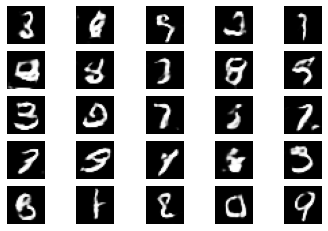

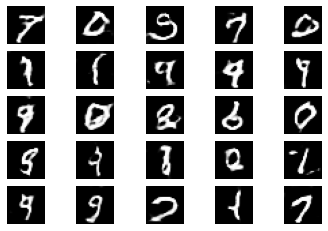

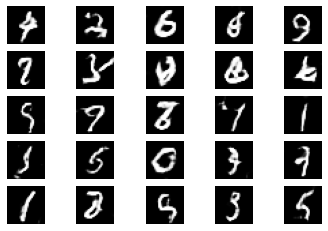

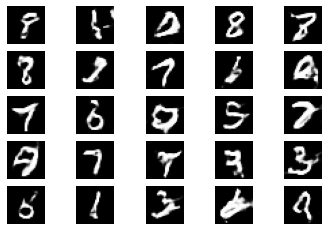

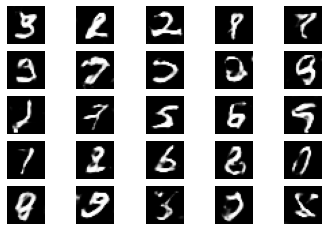

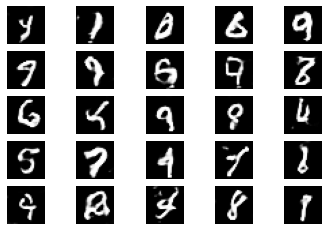

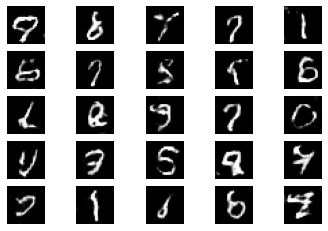

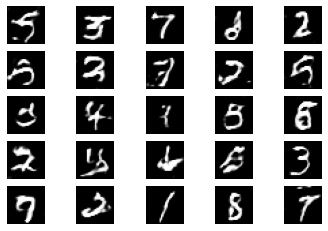

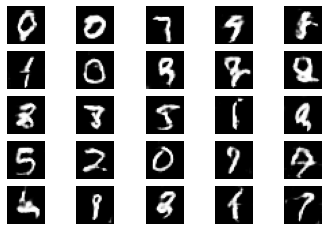

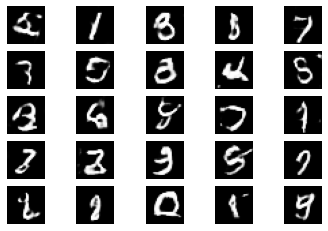

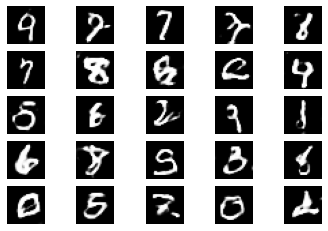

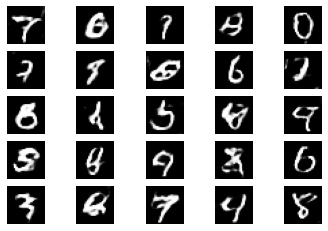

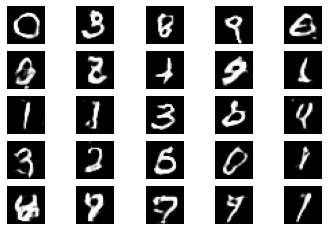

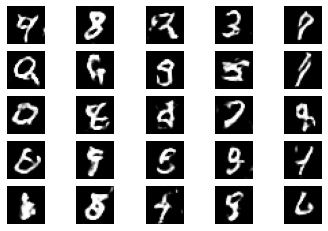

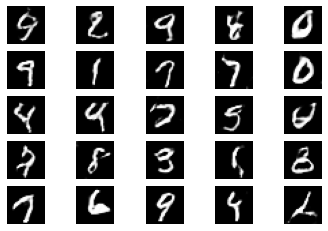

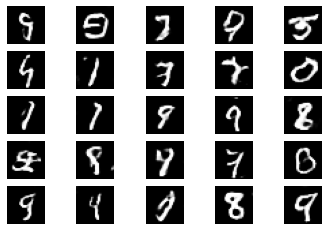

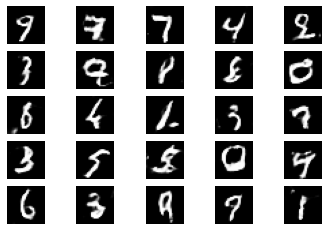

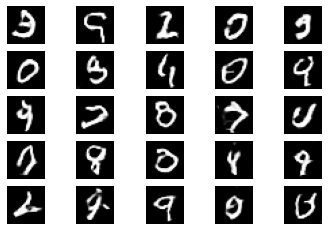

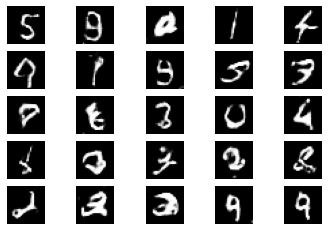

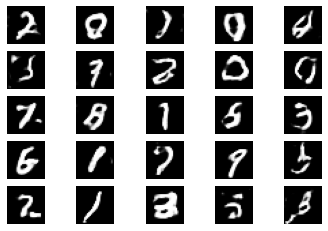

In [39]:
# 신경망 실행시키는 함수 만들고 Mnist 데이터 불러오기


def gan_train(epoch, batch_size, saving_interval):
    # 테스트 과정은 필요없고, 이미지만 사용할 것이므로 X_train만 호출하기
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
    
    # 생성자에서 tanh()함수 사용했었음. 
    # 0~ 255 사이의 픽셀 값에서 127.5를 뺀 후, 127.5로 나누면 -1~1사이의 값으로 바뀐다.
    X_train = (X_train - 127.5) / 127.5
    # batch_size만큼 손글시 이미지 랜덤하게 불러와서 판별자에 집어넣기.
    #실제 이미지를 입력했으므로 모두 참이라는 1이라는 레이블을 가진 배열(1열)만들기
    true = np.ones((batch_size, 1))
    # 가짜 0이라는 레이블을 가진 배열(1열) 만들기.
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        # 실제 이미지를 랜덤으로 불러옴. randint(a, b, c)sms a~b까지의 숫자중 하나를 랜덤하게 가져와서 c번 반복하기.
        # 0부터 x_train 개수 사이의 숫자를 랜덤으로 batch사이즈 만큼 가져옴.
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx] # 위에서 선택된 숫자에 해당하는 이미지 불러오기
        # train_on_batch()함수로 판별 시작. 입력값 x와 레이블 y를 받아서 학습실시하고 모델 업데이트하기.
        d_loss_real = discriminator.train_on_batch(imgs, true) # imgs를 x에 넣고 true값 배열을 y에 놓기
        
        # 가상 이미지를 판별자에 입력하기
        noise = np.random.normal(0, 1, (batch_size, 100)) # 정수가 아니라서 normal함수사용. batch사이즈만큼 100열을 뽑아라.
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # gen_imgs에 가짜(0)이라는 레이블 값이 붙음.
        
        # 판별자와 생성자의 오차 계산하기
        # real이미지 판별값과 fake이미지 판별값을 더해 둘로 나눈 평균이 판별자 오차.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true) # 생성자와 판별자를 연결해서 만든 gan모델을 이용해 생성자 오차 g_loss구하기
        
        print('epoch:%d' % i, 'd_loss: % .4f' % d_loss, 'g_loss: % .4f' % g_loss)
        
        
        # 중간 과정 이미지로 저장하는 과정
        
        if i % saving_interval == 0:
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)
            
            gen_imgs = 0.5 * gen_imgs + 0.5
            
            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap = 'gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig("gan_images/gan_mnist_%d.png" % i)
            
        
        
gan_train(4000, 32, 200) # 4000번 반복되고 +1을 한다. 배치크기 32, 200번마다 결과 저장됨.